## Setup

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random

from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.transforms import ToTensor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

In [39]:
seed = 42
feature_size = 24

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

random.seed(seed)
torch_seed = random.randint(0, 2 ** 32 - 1)
numpy_seed = random.randint(0, 2 ** 32 - 1)
torch.manual_seed(torch_seed)
torch.cuda.manual_seed(torch_seed)
np.random.seed(numpy_seed)

Using device: cuda


In [40]:
def load_data(feature_size: int):
    X = np.load('Datasets/kryptonite-%s-X.npy'%(feature_size))
    y = np.load('Datasets/kryptonite-%s-y.npy'%(feature_size))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test

In [41]:
X_train, y_train, X_test, y_test  = load_data(feature_size)

## Conventional Data Exlporation

In [42]:
df = pd.DataFrame(X_train)

In [43]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,3.840000e+04,3.840000e+04,3.840000e+04,3.840000e+04,3.840000e+04,3.840000e+04,3.840000e+04,3.840000e+04,3.840000e+04,3.840000e+04,...,3.840000e+04,3.840000e+04,3.840000e+04,3.840000e+04,3.840000e+04,3.840000e+04,3.840000e+04,3.840000e+04,3.840000e+04,3.840000e+04
mean,-1.192093e-08,-1.291434e-09,-1.291434e-08,-7.549922e-09,-8.344650e-09,-1.589457e-08,-3.675620e-09,6.755193e-09,1.380841e-08,-9.387731e-09,...,2.384186e-09,-1.291434e-09,-1.887480e-09,1.748403e-08,5.364418e-09,2.582868e-09,3.973643e-10,-8.344650e-09,-1.430511e-08,8.543332e-09
std,1.000013e+00,1.000012e+00,1.000014e+00,1.000013e+00,1.000013e+00,1.000014e+00,1.000012e+00,1.000010e+00,1.000011e+00,1.000010e+00,...,1.000013e+00,1.000015e+00,1.000014e+00,1.000013e+00,1.000015e+00,1.000013e+00,1.000013e+00,1.000014e+00,1.000010e+00,1.000013e+00
min,-1.050105e+00,-1.984403e+00,-1.909024e+00,-1.036844e+00,-2.099250e+00,-1.763919e+00,-1.047922e+00,-2.030849e+00,-1.054099e+00,-1.718456e+00,...,-1.799289e+00,-1.057523e+00,-1.948798e+00,-1.843133e+00,-1.041055e+00,-1.850261e+00,-1.909131e+00,-1.945239e+00,-1.738456e+00,-1.053313e+00
25%,-1.000458e+00,-9.993715e-01,-9.790429e-01,-9.877755e-01,-9.818030e-01,-9.824414e-01,-9.977653e-01,-9.907863e-01,-1.003756e+00,-9.781262e-01,...,-9.746376e-01,-1.007847e+00,-9.822746e-01,-9.843715e-01,-9.907694e-01,-9.983816e-01,-9.881090e-01,-9.947690e-01,-9.839920e-01,-1.003515e+00
50%,9.490419e-01,5.885183e-01,-4.046938e-01,-9.380731e-01,-5.837731e-01,3.762542e-01,-9.481269e-01,-1.811592e-01,9.456027e-01,-4.618244e-01,...,-4.904076e-01,9.420412e-01,-5.623323e-01,4.719940e-01,-9.419933e-01,5.862355e-01,-4.812859e-01,5.119657e-01,-5.524451e-01,9.461874e-01
75%,9.985645e-01,9.805151e-01,9.825489e-01,1.011337e+00,9.991830e-01,9.806200e-01,1.001346e+00,9.902687e-01,9.954522e-01,9.841080e-01,...,9.832233e-01,9.920529e-01,9.967598e-01,9.773689e-01,1.008081e+00,9.815676e-01,9.916115e-01,9.855318e-01,9.958431e-01,9.956850e-01
max,1.048906e+00,1.880364e+00,1.819492e+00,1.062169e+00,2.101738e+00,1.874907e+00,1.051349e+00,1.886570e+00,1.045074e+00,1.761420e+00,...,1.816606e+00,1.041126e+00,1.993747e+00,1.808759e+00,1.058251e+00,1.774927e+00,2.049588e+00,2.155959e+00,1.910789e+00,1.045673e+00


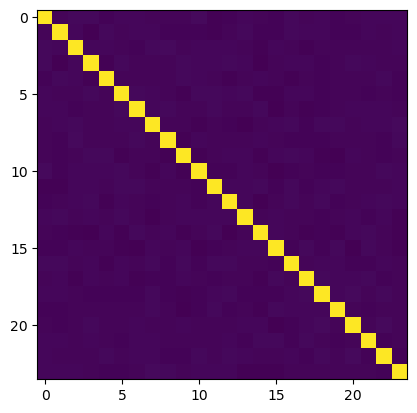

In [44]:
corr = df.corr()
plt.imshow(corr)
plt.show()

<Axes: ylabel='Density'>

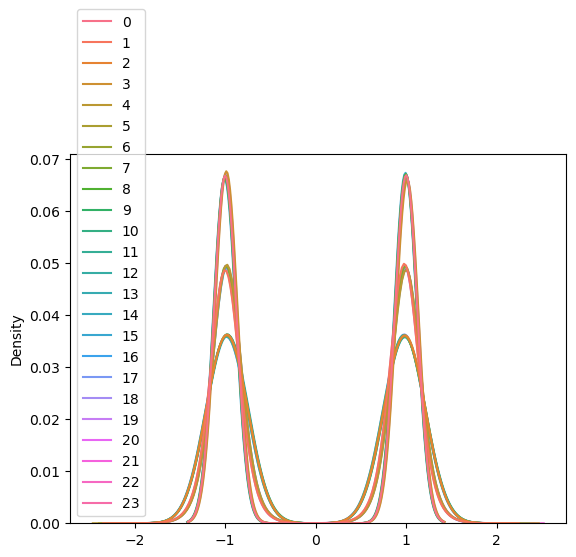

In [45]:
sns.kdeplot(data=df)

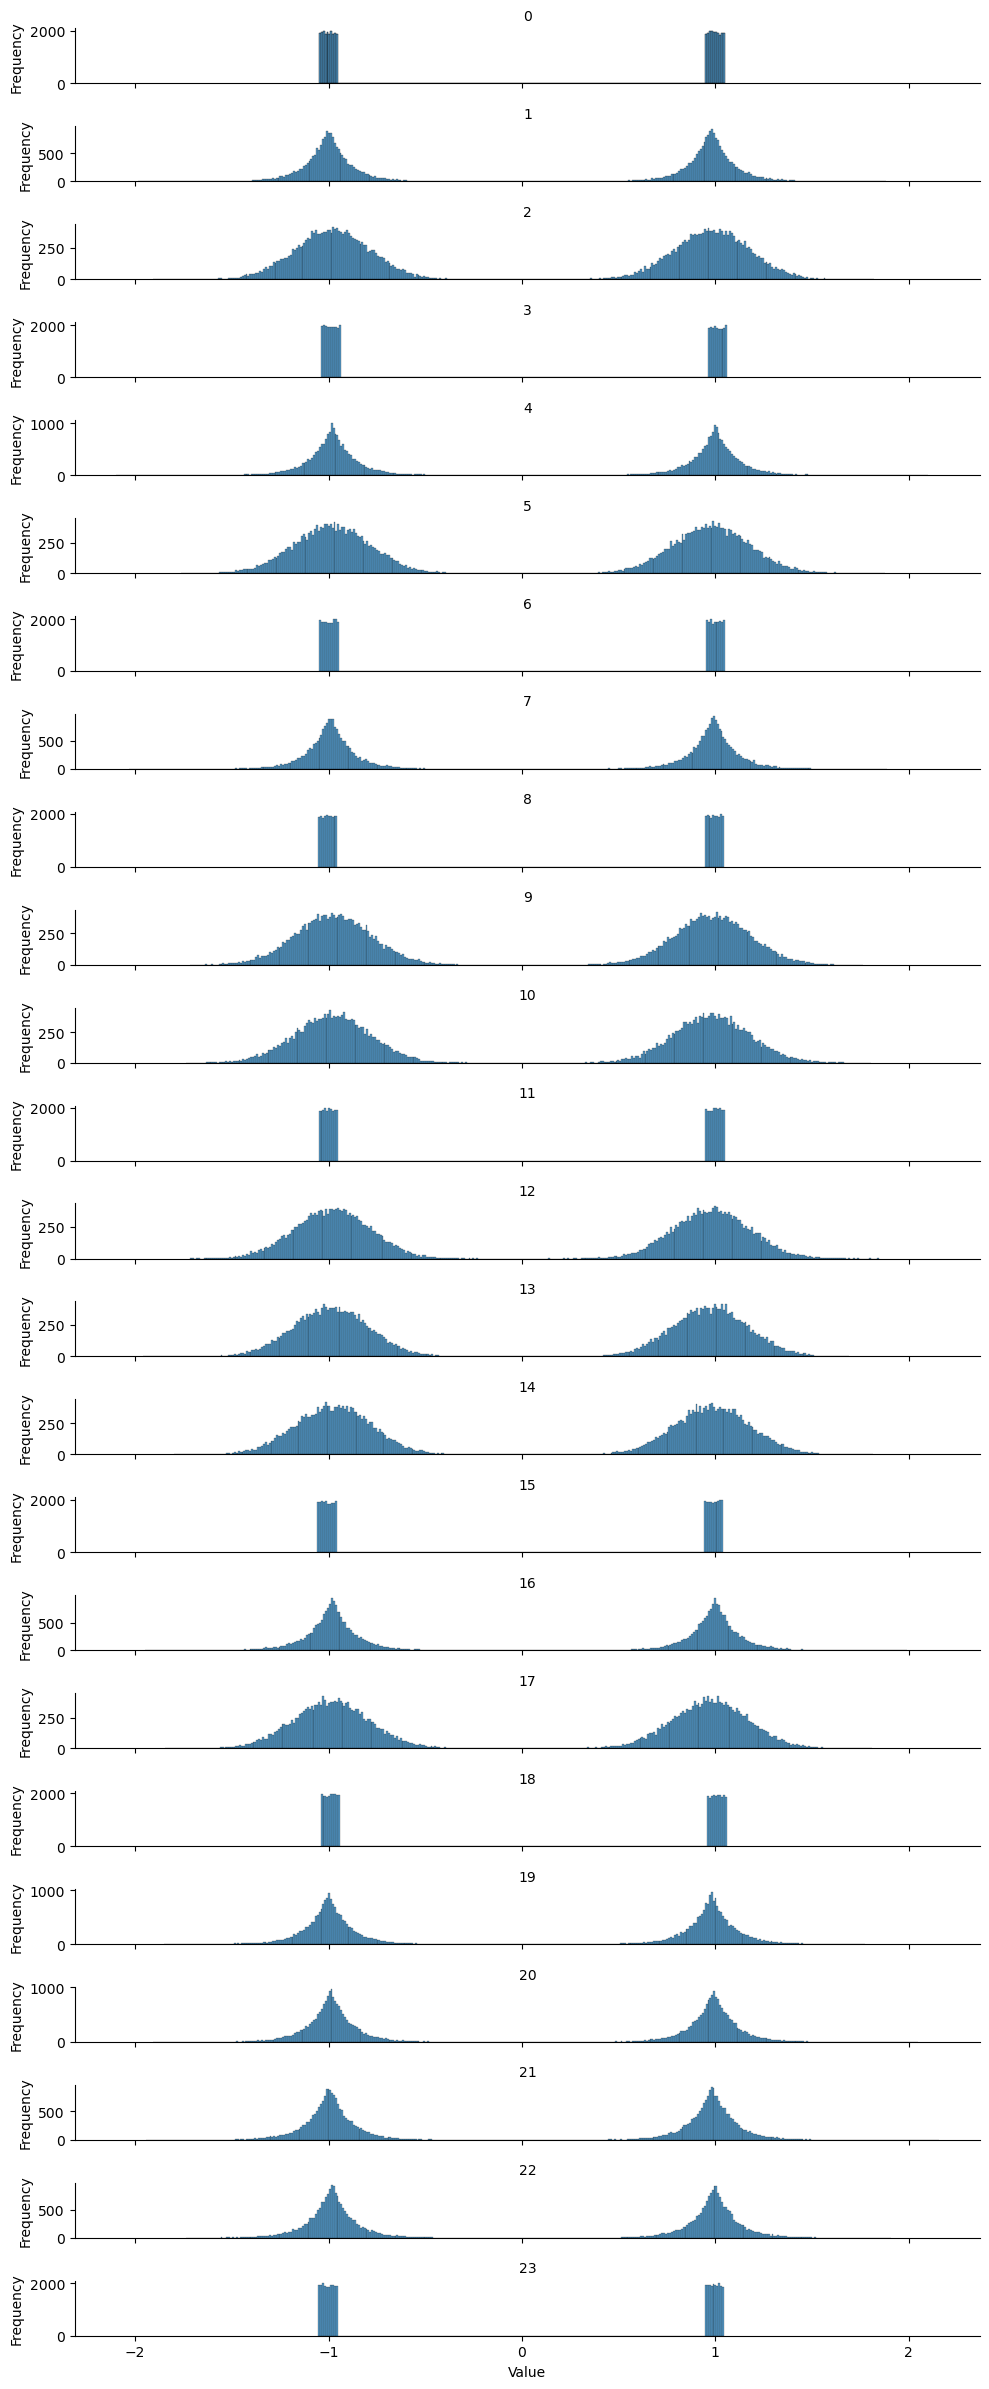

In [46]:
df_melt = pd.melt(df, var_name='features', value_name='Value')

g = sns.FacetGrid(df_melt, row='features', aspect=10, height=1, sharex=True, sharey=False)
g.map(sns.histplot, 'Value', binwidth=0.01)

g.set_titles("{row_name}")
g.set_axis_labels("Value", "Frequency")
g.tight_layout()
plt.show()

In [47]:
mutual_info_classif(X_train, y_train)

array([0.00089542, 0.00400423, 0.00319943, 0.00192874, 0.00066782,
       0.        , 0.        , 0.        , 0.        , 0.00233051,
       0.        , 0.00051805, 0.        , 0.        , 0.        ,
       0.        , 0.00590551, 0.00017876, 0.        , 0.        ,
       0.        , 0.        , 0.00089165, 0.        ])